## **IMPORT LIBRARY**

In [ ]:
import pandas as pd
import torch
import string
import re
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [ ]:
# Baca file CSV
file_path = 'Data aspek-aspek.csv'
data = pd.read_csv(file_path)

## **Data Preprocessing**

In [ ]:
# Fungsi untuk menghapus tanda baca dan emotikon
def remove_punctuation_and_emoticons(text):
    translator = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(translator)
    text_no_emoticons = re.sub(r'[^\x00-\x7F]+', ' ', text_no_punct)  # Menghapus emotikon
    return text_no_emoticons

In [ ]:
# Terapkan preprocessing pada kolom 'ulasan' dalam DataFrame
data['ulasan'] = data['ulasan'].apply(lambda x: remove_punctuation_and_emoticons(x.lower()))

# Menampilkan hasil
print(data.head())

                                     ulasan  Fitur  Pelayanan  Religiusitas  \
0                             qaraa mantapp      0          0             0   
1                                     bagus      0          0             0   
2                           good aplication      0          0             0   
3             aplikasi bagus sangat berguna      0          0             0   
4  aplikasi al quran terlengkap dan terbaik      2          0             0   

   Pengalaman  Umum  
0           0     2  
1           0     2  
2           0     2  
3           2     0  
4           0     2  


In [ ]:
# Melt data agar setiap baris mewakili satu aspek dan sentimen
columns = ['Fitur', 'Pelayanan', 'Pengalaman', 'Religiusitas', 'Umum']
data = data.melt(id_vars=['ulasan'], value_vars=columns, var_name='aspek', value_name='sentimen')

# Hapus baris dengan sentimen 0
data = data[data['sentimen'] != 0]

# Encode aspek dan sentimen
aspect_encoder = LabelEncoder()
data['aspek_encoded'] = aspect_encoder.fit_transform(data['aspek'])
sentiment_encoder = LabelEncoder()
data['sentimen_encoded'] = sentiment_encoder.fit_transform(data['sentimen'])

# Membuat data multi-label untuk aspek
aspect_labels_multi = []
for _, row in data.iterrows():
    aspect_labels = [0] * len(aspect_encoder.classes_)
    aspect_labels[row['aspek_encoded']] = 1
    aspect_labels_multi.append(aspect_labels)

data['aspek_multi'] = aspect_labels_multi

## **Split Data**

In [ ]:
from sklearn.model_selection import train_test_split

# Split data menjadi train dan test dengan 80% data untuk training dan 20% untuk validasi
train_texts, val_texts, train_aspects, val_aspects, train_sentiments, val_sentiments = train_test_split(
    data['ulasan'].tolist(),
    data['aspek_multi'].tolist(),
    data['sentimen_encoded'].tolist(),
    test_size=0.2, # Ubah ke 0.2 untuk 20% data validasi
    random_state=42
)

# Pastikan bentuk data setelah split sesuai
print(f"Jumlah data total: {len(data)}")
print(f"Jumlah data untuk training: {len(train_texts)}")
print(f"Jumlah data untuk validasi: {len(val_texts)}")


Jumlah data total: 2037
Jumlah data untuk training: 1629
Jumlah data untuk validasi: 408


## **Tokenizer**

In [ ]:
# Tokenizer Multilingual BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Tokenisasi teks
def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

## **Data Loader**

In [ ]:
# Dataset untuk DataLoader
class MultiTaskDataset(Dataset):
    def __init__(self, encodings, aspects, sentiments):
        self.encodings = encodings
        self.aspects = aspects
        self.sentiments = sentiments

    def __len__(self):
        return len(self.aspects)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["aspect"] = torch.tensor(self.aspects[idx], dtype=torch.float)  # Ubah ke tipe float untuk multi-label
        item["sentiment"] = torch.tensor(self.sentiments[idx])
        return item

# Model BERT Multi-Task (menggunakan sigmoid untuk multi-label aspek)
class BertMultiTask(nn.Module):
    def __init__(self, num_aspects, num_sentiments):
        super(BertMultiTask, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.aspect_classifier = nn.Linear(self.bert.config.hidden_size, num_aspects)  # Aspek classifier untuk multi-label
        self.sentiment_classifier = nn.Linear(self.bert.config.hidden_size, num_sentiments)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token output
        aspect_logits = self.aspect_classifier(cls_output)  # Tidak perlu softmax untuk multi-label
        sentiment_logits = self.sentiment_classifier(cls_output)
        return aspect_logits, sentiment_logits

train_dataset = MultiTaskDataset(train_encodings, train_aspects, train_sentiments)
val_dataset = MultiTaskDataset(val_encodings, val_aspects, val_sentiments)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

## **Optimizer**

In [ ]:
# Inisialisasi model
num_aspects = len(aspect_encoder.classes_)
num_sentiments = len(sentiment_encoder.classes_)
model = BertMultiTask(num_aspects, num_sentiments)

# Optimizer dan Loss
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion_aspect = nn.BCEWithLogitsLoss()  # Menggunakan BCE dengan logits untuk multi-label
criterion_sentiment = nn.CrossEntropyLoss()


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

## **Training & Evaluasi**

In [ ]:
def train(model, train_loader, val_loader, epochs=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            aspect_labels = batch["aspect"].to(device)
            sentiment_labels = batch["sentiment"].to(device)

            aspect_logits, sentiment_logits = model(input_ids, attention_mask)
            loss_aspect = criterion_aspect(aspect_logits, aspect_labels)
            loss_sentiment = criterion_sentiment(sentiment_logits, sentiment_labels)
            loss = loss_aspect + loss_sentiment

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")

        # Evaluasi
        model.eval()
        val_loss = 0
        aspect_preds, sentiment_preds = [], []
        aspect_targets, sentiment_targets = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                aspect_labels = batch["aspect"].to(device)
                sentiment_labels = batch["sentiment"].to(device)

                aspect_logits, sentiment_logits = model(input_ids, attention_mask)
                loss_aspect = criterion_aspect(aspect_logits, aspect_labels)
                loss_sentiment = criterion_sentiment(sentiment_logits, sentiment_labels)
                val_loss += (loss_aspect + loss_sentiment).item()

                # Prediksi Aspek dan Sentimen
                aspect_probs = torch.sigmoid(aspect_logits)
                aspect_preds.extend((aspect_probs > 0.5).int().cpu().numpy())
                sentiment_preds.extend(torch.argmax(sentiment_logits, dim=1).cpu().numpy())
                aspect_targets.extend(aspect_labels.cpu().numpy())
                sentiment_targets.extend(sentiment_labels.cpu().numpy())

        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss/len(val_loader):.4f}")
        print("Aspect Classification Report:")
        print(classification_report(aspect_targets, aspect_preds, target_names=aspect_encoder.classes_))

        sentiment_target_names = [str(cls) for cls in sentiment_encoder.classes_]
        print("Sentiment Classification Report:")
        print(classification_report(sentiment_targets, sentiment_preds, target_names=sentiment_target_names))

    # Mengembalikan hasil evaluasi
    return aspect_targets, aspect_preds, sentiment_targets, sentiment_preds

# Mulai pelatihan
train(model, train_loader, val_loader)

# Simpan model
model_save_path = "./bert-multilingual-multitask"
torch.save(model.state_dict(), model_save_path)
print(f"Model disimpan di {model_save_path}")

Epoch 1/15, Train Loss: 1.1457
Epoch 1/15, Val Loss: 0.9140
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.45      0.05      0.09       104
   Pelayanan       0.00      0.00      0.00        12
  Pengalaman       0.52      0.31      0.38        95
Religiusitas       0.00      0.00      0.00        29
        Umum       0.86      0.56      0.68       168

   micro avg       0.73      0.31      0.44       408
   macro avg       0.37      0.18      0.23       408
weighted avg       0.59      0.31      0.39       408
 samples avg       0.31      0.31      0.31       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.73      0.83      0.78       147
           1       0.83      0.72      0.77        95
           2       0.81      0.78      0.79       166

    accuracy                           0.78       408
   macro avg       0.79      0.77      0.78       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/15, Train Loss: 0.7948
Epoch 2/15, Val Loss: 0.9334
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.58      0.33      0.42       104
   Pelayanan       0.00      0.00      0.00        12
  Pengalaman       0.53      0.26      0.35        95
Religiusitas       0.78      0.24      0.37        29
        Umum       0.97      0.53      0.68       168

   micro avg       0.75      0.38      0.50       408
   macro avg       0.57      0.27      0.36       408
weighted avg       0.72      0.38      0.50       408
 samples avg       0.37      0.38      0.38       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.73      0.76      0.74       147
           1       0.98      0.59      0.74        95
           2       0.71      0.84      0.77       166

    accuracy                           0.75       408
   macro avg       0.81      0.73      0.75       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/15, Train Loss: 0.6515
Epoch 3/15, Val Loss: 0.8649
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.50      0.53      0.51       104
   Pelayanan       0.00      0.00      0.00        12
  Pengalaman       0.57      0.32      0.41        95
Religiusitas       0.71      0.34      0.47        29
        Umum       0.92      0.62      0.74       168

   micro avg       0.68      0.49      0.57       408
   macro avg       0.54      0.36      0.42       408
weighted avg       0.69      0.49      0.56       408
 samples avg       0.46      0.49      0.47       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.72      0.77      0.74       147
           1       0.87      0.76      0.81        95
           2       0.76      0.77      0.76       166

    accuracy                           0.76       408
   macro avg       0.78      0.76      0.77       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/15, Train Loss: 0.5800
Epoch 4/15, Val Loss: 0.8506
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.58      0.32      0.41       104
   Pelayanan       0.00      0.00      0.00        12
  Pengalaman       0.64      0.38      0.48        95
Religiusitas       0.67      0.28      0.39        29
        Umum       0.90      0.63      0.74       168

   micro avg       0.75      0.45      0.56       408
   macro avg       0.56      0.32      0.40       408
weighted avg       0.71      0.45      0.55       408
 samples avg       0.45      0.45      0.45       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.73      0.77      0.75       147
           1       0.89      0.77      0.82        95
           2       0.76      0.78      0.77       166

    accuracy                           0.77       408
   macro avg       0.79      0.77      0.78       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/15, Train Loss: 0.5279
Epoch 5/15, Val Loss: 0.9397
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.60      0.41      0.49       104
   Pelayanan       0.00      0.00      0.00        12
  Pengalaman       0.55      0.48      0.52        95
Religiusitas       0.69      0.31      0.43        29
        Umum       0.91      0.62      0.74       168

   micro avg       0.71      0.50      0.59       408
   macro avg       0.55      0.37      0.43       408
weighted avg       0.70      0.50      0.58       408
 samples avg       0.50      0.50      0.50       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.80      0.69      0.74       147
           1       0.88      0.77      0.82        95
           2       0.72      0.86      0.78       166

    accuracy                           0.78       408
   macro avg       0.80      0.77      0.78       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/15, Train Loss: 0.5002
Epoch 6/15, Val Loss: 0.9330
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.52      0.47      0.49       104
   Pelayanan       0.00      0.00      0.00        12
  Pengalaman       0.56      0.45      0.50        95
Religiusitas       0.48      0.38      0.42        29
        Umum       0.89      0.62      0.73       168

   micro avg       0.67      0.51      0.58       408
   macro avg       0.49      0.39      0.43       408
weighted avg       0.66      0.51      0.58       408
 samples avg       0.51      0.51      0.51       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.72      0.80      0.75       147
           1       0.87      0.79      0.83        95
           2       0.78      0.75      0.76       166

    accuracy                           0.77       408
   macro avg       0.79      0.78      0.78       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/15, Train Loss: 0.4688
Epoch 7/15, Val Loss: 0.9432
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.67      0.31      0.42       104
   Pelayanan       0.00      0.00      0.00        12
  Pengalaman       0.51      0.59      0.55        95
Religiusitas       0.67      0.34      0.45        29
        Umum       0.86      0.64      0.73       168

   micro avg       0.69      0.50      0.58       408
   macro avg       0.54      0.38      0.43       408
weighted avg       0.69      0.50      0.57       408
 samples avg       0.50      0.50      0.50       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.72      0.71      0.71       147
           1       0.84      0.80      0.82        95
           2       0.75      0.78      0.77       166

    accuracy                           0.76       408
   macro avg       0.77      0.76      0.77       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/15, Train Loss: 0.4401
Epoch 8/15, Val Loss: 1.0287
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.57      0.50      0.53       104
   Pelayanan       0.00      0.00      0.00        12
  Pengalaman       0.50      0.52      0.51        95
Religiusitas       0.59      0.34      0.43        29
        Umum       0.86      0.64      0.73       168

   micro avg       0.66      0.54      0.59       408
   macro avg       0.50      0.40      0.44       408
weighted avg       0.66      0.54      0.59       408
 samples avg       0.54      0.54      0.54       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.70      0.74      0.72       147
           1       0.86      0.78      0.82        95
           2       0.75      0.75      0.75       166

    accuracy                           0.75       408
   macro avg       0.77      0.76      0.76       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/15, Train Loss: 0.4063
Epoch 9/15, Val Loss: 1.1064
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.50      0.55      0.52       104
   Pelayanan       0.00      0.00      0.00        12
  Pengalaman       0.55      0.31      0.39        95
Religiusitas       0.45      0.45      0.45        29
        Umum       0.83      0.62      0.71       168

   micro avg       0.63      0.50      0.56       408
   macro avg       0.47      0.38      0.41       408
weighted avg       0.63      0.50      0.55       408
 samples avg       0.50      0.50      0.50       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.69      0.73      0.71       147
           1       0.88      0.75      0.81        95
           2       0.74      0.77      0.75       166

    accuracy                           0.75       408
   macro avg       0.77      0.75      0.76       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/15, Train Loss: 0.3910
Epoch 10/15, Val Loss: 1.1278
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.52      0.61      0.56       104
   Pelayanan       0.00      0.00      0.00        12
  Pengalaman       0.54      0.44      0.49        95
Religiusitas       0.59      0.34      0.43        29
        Umum       0.80      0.63      0.71       168

   micro avg       0.64      0.54      0.58       408
   macro avg       0.49      0.40      0.44       408
weighted avg       0.63      0.54      0.58       408
 samples avg       0.54      0.54      0.54       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.69      0.74      0.72       147
           1       0.80      0.79      0.79        95
           2       0.76      0.72      0.74       166

    accuracy                           0.75       408
   macro avg       0.75      0.75      0.75       408
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/15, Train Loss: 0.3915
Epoch 11/15, Val Loss: 1.1464
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.53      0.44      0.48       104
   Pelayanan       0.50      0.08      0.14        12
  Pengalaman       0.52      0.42      0.47        95
Religiusitas       0.48      0.38      0.42        29
        Umum       0.79      0.65      0.71       168

   micro avg       0.63      0.51      0.56       408
   macro avg       0.56      0.39      0.45       408
weighted avg       0.63      0.51      0.56       408
 samples avg       0.50      0.51      0.50       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.72      0.73      0.72       147
           1       0.85      0.77      0.81        95
           2       0.75      0.78      0.76       166

    accuracy                           0.76       408
   macro avg       0.77      0.76      0.76       408
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/15, Train Loss: 0.3761
Epoch 12/15, Val Loss: 1.3077
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.57      0.38      0.45       104
   Pelayanan       0.67      0.17      0.27        12
  Pengalaman       0.48      0.61      0.54        95
Religiusitas       0.58      0.38      0.46        29
        Umum       0.78      0.64      0.71       168

   micro avg       0.62      0.53      0.58       408
   macro avg       0.62      0.43      0.48       408
weighted avg       0.64      0.53      0.57       408
 samples avg       0.53      0.53      0.53       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.69      0.71      0.70       147
           1       0.78      0.82      0.80        95
           2       0.77      0.72      0.74       166

    accuracy                           0.74       408
   macro avg       0.74      0.75      0.75       408
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13/15, Train Loss: 0.3541
Epoch 13/15, Val Loss: 1.3093
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.54      0.42      0.48       104
   Pelayanan       0.67      0.17      0.27        12
  Pengalaman       0.46      0.44      0.45        95
Religiusitas       0.41      0.62      0.49        29
        Umum       0.80      0.65      0.72       168

   micro avg       0.61      0.53      0.57       408
   macro avg       0.58      0.46      0.48       408
weighted avg       0.63      0.53      0.57       408
 samples avg       0.52      0.53      0.52       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.70      0.76      0.73       147
           1       0.90      0.78      0.84        95
           2       0.75      0.75      0.75       166

    accuracy                           0.76       408
   macro avg       0.79      0.76      0.77       408
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/15, Train Loss: 0.3403
Epoch 14/15, Val Loss: 1.2944
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.51      0.42      0.46       104
   Pelayanan       0.60      0.25      0.35        12
  Pengalaman       0.46      0.54      0.49        95
Religiusitas       0.42      0.48      0.45        29
        Umum       0.79      0.64      0.70       168

   micro avg       0.59      0.54      0.56       408
   macro avg       0.56      0.47      0.49       408
weighted avg       0.61      0.54      0.57       408
 samples avg       0.52      0.54      0.53       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.69      0.75      0.72       147
           1       0.81      0.80      0.80        95
           2       0.79      0.73      0.76       166

    accuracy                           0.75       408
   macro avg       0.76      0.76      0.76       408
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/15, Train Loss: 0.3234
Epoch 15/15, Val Loss: 1.4583
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.46      0.48      0.47       104
   Pelayanan       0.33      0.08      0.13        12
  Pengalaman       0.44      0.48      0.46        95
Religiusitas       0.55      0.38      0.45        29
        Umum       0.77      0.63      0.70       168

   micro avg       0.57      0.52      0.55       408
   macro avg       0.51      0.41      0.44       408
weighted avg       0.59      0.52      0.55       408
 samples avg       0.51      0.52      0.52       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.69      0.76      0.72       147
           1       0.84      0.80      0.82        95
           2       0.78      0.72      0.75       166

    accuracy                           0.75       408
   macro avg       0.77      0.76      0.76       408
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model disimpan di ./bert-multilingual-multitask


## **Confusion Matrix**

Epoch 1/15, Train Loss: 0.3215
Epoch 1/15, Val Loss: 1.3725
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.49      0.48      0.48       104
   Pelayanan       0.60      0.25      0.35        12
  Pengalaman       0.45      0.51      0.48        95
Religiusitas       0.42      0.45      0.43        29
        Umum       0.79      0.63      0.70       168

   micro avg       0.58      0.54      0.56       408
   macro avg       0.55      0.46      0.49       408
weighted avg       0.60      0.54      0.56       408
 samples avg       0.53      0.54      0.53       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.69      0.74      0.71       147
           1       0.85      0.79      0.82        95
           2       0.77      0.75      0.76       166

    accuracy                           0.75       408
   macro avg       0.77      0.76      0.76       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/15, Train Loss: 0.3156
Epoch 2/15, Val Loss: 1.5276
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.47      0.60      0.53       104
   Pelayanan       0.60      0.25      0.35        12
  Pengalaman       0.43      0.41      0.42        95
Religiusitas       0.38      0.52      0.44        29
        Umum       0.84      0.61      0.71       168

   micro avg       0.57      0.54      0.56       408
   macro avg       0.55      0.48      0.49       408
weighted avg       0.61      0.54      0.57       408
 samples avg       0.53      0.54      0.53       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.68      0.80      0.73       147
           1       0.86      0.76      0.80        95
           2       0.79      0.72      0.75       166

    accuracy                           0.75       408
   macro avg       0.77      0.76      0.76       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/15, Train Loss: 0.3056
Epoch 3/15, Val Loss: 1.6183
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.45      0.56      0.50       104
   Pelayanan       0.50      0.17      0.25        12
  Pengalaman       0.47      0.38      0.42        95
Religiusitas       0.53      0.34      0.42        29
        Umum       0.76      0.64      0.69       168

   micro avg       0.58      0.52      0.55       408
   macro avg       0.54      0.42      0.46       408
weighted avg       0.59      0.52      0.55       408
 samples avg       0.52      0.52      0.52       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.68      0.71      0.69       147
           1       0.83      0.78      0.80        95
           2       0.74      0.73      0.74       166

    accuracy                           0.74       408
   macro avg       0.75      0.74      0.74       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/15, Train Loss: 0.3146
Epoch 4/15, Val Loss: 1.6047
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.49      0.38      0.43       104
   Pelayanan       0.50      0.33      0.40        12
  Pengalaman       0.46      0.44      0.45        95
Religiusitas       0.44      0.38      0.41        29
        Umum       0.72      0.68      0.70       168

   micro avg       0.58      0.52      0.55       408
   macro avg       0.52      0.44      0.48       408
weighted avg       0.58      0.52      0.54       408
 samples avg       0.51      0.52      0.51       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.67      0.75      0.71       147
           1       0.78      0.78      0.78        95
           2       0.78      0.70      0.74       166

    accuracy                           0.74       408
   macro avg       0.74      0.74      0.74       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/15, Train Loss: 0.2991
Epoch 5/15, Val Loss: 1.6911
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.49      0.47      0.48       104
   Pelayanan       0.50      0.25      0.33        12
  Pengalaman       0.45      0.44      0.45        95
Religiusitas       0.37      0.48      0.42        29
        Umum       0.78      0.64      0.70       168

   micro avg       0.57      0.53      0.55       408
   macro avg       0.52      0.46      0.48       408
weighted avg       0.59      0.53      0.55       408
 samples avg       0.52      0.53      0.52       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.67      0.76      0.71       147
           1       0.85      0.77      0.81        95
           2       0.76      0.72      0.74       166

    accuracy                           0.75       408
   macro avg       0.76      0.75      0.75       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/15, Train Loss: 0.2859
Epoch 6/15, Val Loss: 1.7292
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.43      0.59      0.50       104
   Pelayanan       0.43      0.25      0.32        12
  Pengalaman       0.44      0.28      0.35        95
Religiusitas       0.38      0.55      0.45        29
        Umum       0.80      0.62      0.70       168

   micro avg       0.55      0.52      0.54       408
   macro avg       0.50      0.46      0.46       408
weighted avg       0.58      0.52      0.54       408
 samples avg       0.51      0.52      0.52       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.73      0.69       147
           1       0.81      0.79      0.80        95
           2       0.76      0.70      0.73       166

    accuracy                           0.73       408
   macro avg       0.74      0.74      0.74       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/15, Train Loss: 0.2772
Epoch 7/15, Val Loss: 1.6887
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.47      0.49      0.48       104
   Pelayanan       0.50      0.25      0.33        12
  Pengalaman       0.43      0.31      0.36        95
Religiusitas       0.37      0.62      0.46        29
        Umum       0.74      0.64      0.69       168

   micro avg       0.56      0.51      0.53       408
   macro avg       0.50      0.46      0.46       408
weighted avg       0.57      0.51      0.53       408
 samples avg       0.51      0.51      0.51       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.69      0.73      0.71       147
           1       0.85      0.78      0.81        95
           2       0.74      0.73      0.74       166

    accuracy                           0.75       408
   macro avg       0.76      0.75      0.75       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/15, Train Loss: 0.2741
Epoch 8/15, Val Loss: 1.6352
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.44      0.56      0.49       104
   Pelayanan       0.40      0.17      0.24        12
  Pengalaman       0.46      0.34      0.39        95
Religiusitas       0.39      0.48      0.43        29
        Umum       0.78      0.62      0.70       168

   micro avg       0.56      0.52      0.54       408
   macro avg       0.50      0.43      0.45       408
weighted avg       0.58      0.52      0.54       408
 samples avg       0.51      0.52      0.51       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.76      0.71       147
           1       0.84      0.76      0.80        95
           2       0.77      0.72      0.75       166

    accuracy                           0.74       408
   macro avg       0.76      0.75      0.75       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/15, Train Loss: 0.2634
Epoch 9/15, Val Loss: 1.9082
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.43      0.52      0.47       104
   Pelayanan       0.50      0.25      0.33        12
  Pengalaman       0.46      0.38      0.42        95
Religiusitas       0.39      0.38      0.39        29
        Umum       0.72      0.64      0.68       168

   micro avg       0.54      0.52      0.53       408
   macro avg       0.50      0.43      0.46       408
weighted avg       0.55      0.52      0.53       408
 samples avg       0.51      0.52      0.51       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.69      0.67       147
           1       0.84      0.78      0.81        95
           2       0.72      0.73      0.73       166

    accuracy                           0.73       408
   macro avg       0.74      0.73      0.74       408
weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/15, Train Loss: 0.2817
Epoch 10/15, Val Loss: 1.6884
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.42      0.31      0.36       104
   Pelayanan       0.60      0.25      0.35        12
  Pengalaman       0.44      0.55      0.49        95
Religiusitas       0.52      0.38      0.44        29
        Umum       0.69      0.66      0.67       168

   micro avg       0.55      0.51      0.53       408
   macro avg       0.53      0.43      0.46       408
weighted avg       0.55      0.51      0.52       408
 samples avg       0.50      0.51      0.51       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.68      0.71      0.70       147
           1       0.82      0.80      0.81        95
           2       0.74      0.73      0.74       166

    accuracy                           0.74       408
   macro avg       0.75      0.75      0.75       408
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/15, Train Loss: 0.2705
Epoch 11/15, Val Loss: 1.8885
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.44      0.35      0.39       104
   Pelayanan       0.50      0.25      0.33        12
  Pengalaman       0.42      0.40      0.41        95
Religiusitas       0.35      0.48      0.41        29
        Umum       0.75      0.64      0.69       168

   micro avg       0.55      0.49      0.51       408
   macro avg       0.49      0.42      0.45       408
weighted avg       0.56      0.49      0.52       408
 samples avg       0.48      0.49      0.48       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.69      0.72      0.70       147
           1       0.82      0.79      0.80        95
           2       0.75      0.73      0.74       166

    accuracy                           0.74       408
   macro avg       0.75      0.75      0.75       408
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/15, Train Loss: 0.2708
Epoch 12/15, Val Loss: 1.9536
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.48      0.46      0.47       104
   Pelayanan       0.43      0.25      0.32        12
  Pengalaman       0.46      0.45      0.46        95
Religiusitas       0.36      0.48      0.41        29
        Umum       0.74      0.63      0.68       168

   micro avg       0.56      0.52      0.54       408
   macro avg       0.49      0.46      0.47       408
weighted avg       0.57      0.52      0.55       408
 samples avg       0.52      0.52      0.52       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.68      0.73      0.70       147
           1       0.81      0.80      0.80        95
           2       0.76      0.72      0.74       166

    accuracy                           0.74       408
   macro avg       0.75      0.75      0.75       408
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13/15, Train Loss: 0.2643
Epoch 13/15, Val Loss: 1.8292
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.46      0.38      0.41       104
   Pelayanan       0.30      0.25      0.27        12
  Pengalaman       0.43      0.42      0.43        95
Religiusitas       0.42      0.45      0.43        29
        Umum       0.71      0.65      0.68       168

   micro avg       0.55      0.50      0.52       408
   macro avg       0.47      0.43      0.45       408
weighted avg       0.55      0.50      0.52       408
 samples avg       0.50      0.50      0.50       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.68      0.71      0.69       147
           1       0.88      0.76      0.81        95
           2       0.73      0.76      0.75       166

    accuracy                           0.74       408
   macro avg       0.76      0.74      0.75       408
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/15, Train Loss: 0.2472
Epoch 14/15, Val Loss: 2.0061
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.45      0.51      0.48       104
   Pelayanan       0.50      0.25      0.33        12
  Pengalaman       0.39      0.33      0.36        95
Religiusitas       0.34      0.48      0.40        29
        Umum       0.72      0.64      0.68       168

   micro avg       0.53      0.51      0.52       408
   macro avg       0.48      0.44      0.45       408
weighted avg       0.54      0.51      0.52       408
 samples avg       0.51      0.51      0.51       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.75      0.70       147
           1       0.85      0.74      0.79        95
           2       0.75      0.72      0.74       166

    accuracy                           0.74       408
   macro avg       0.76      0.74      0.74       408
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/15, Train Loss: 0.2566
Epoch 15/15, Val Loss: 1.9721
Aspect Classification Report:
              precision    recall  f1-score   support

       Fitur       0.45      0.48      0.46       104
   Pelayanan       0.50      0.25      0.33        12
  Pengalaman       0.46      0.45      0.46        95
Religiusitas       0.40      0.34      0.37        29
        Umum       0.73      0.64      0.68       168

   micro avg       0.56      0.52      0.54       408
   macro avg       0.51      0.43      0.46       408
weighted avg       0.56      0.52      0.54       408
 samples avg       0.52      0.52      0.52       408

Sentiment Classification Report:
              precision    recall  f1-score   support

          -1       0.67      0.72      0.70       147
           1       0.87      0.75      0.80        95
           2       0.74      0.75      0.74       166

    accuracy                           0.74       408
   macro avg       0.76      0.74      0.75       408
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


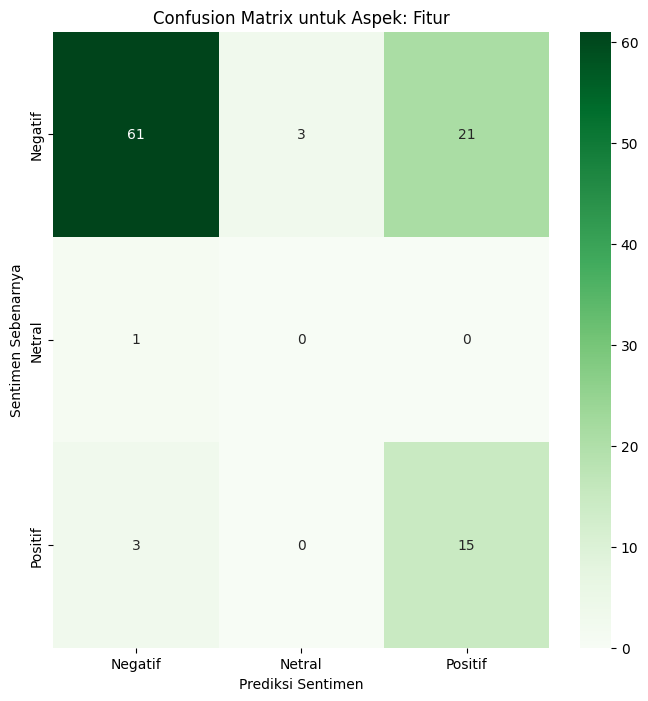

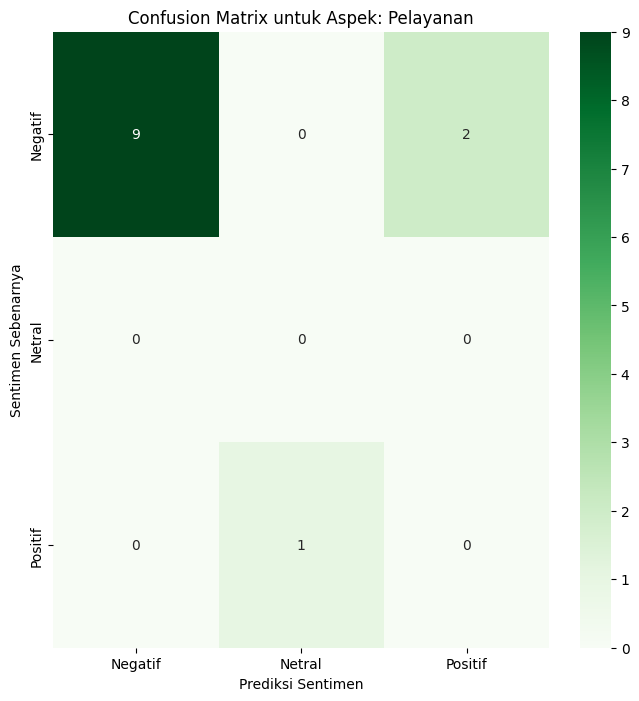

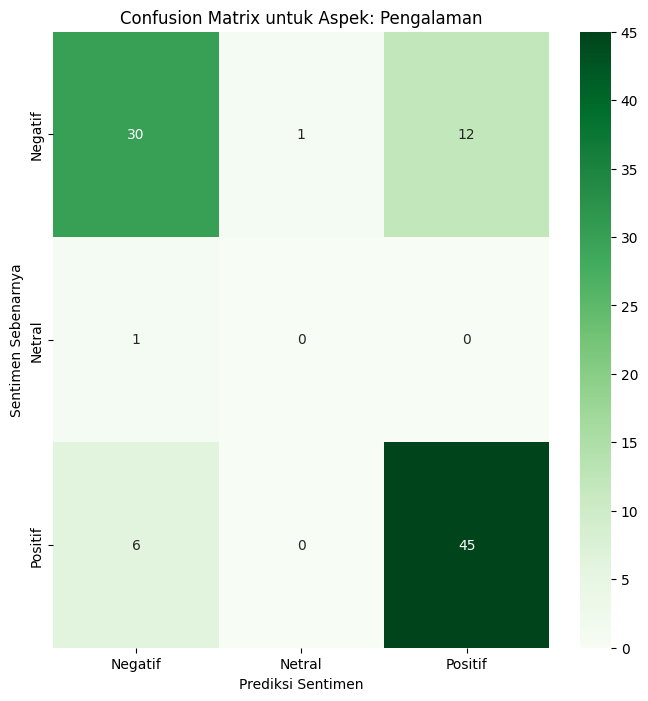

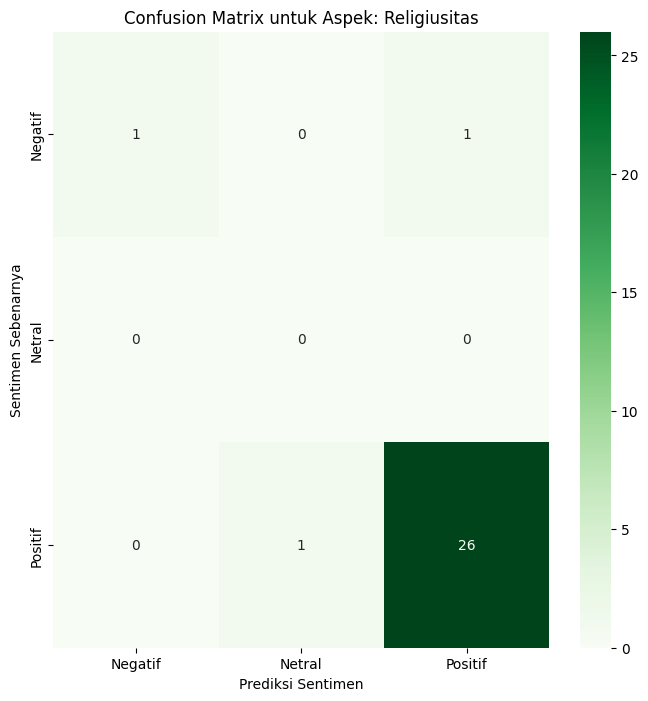

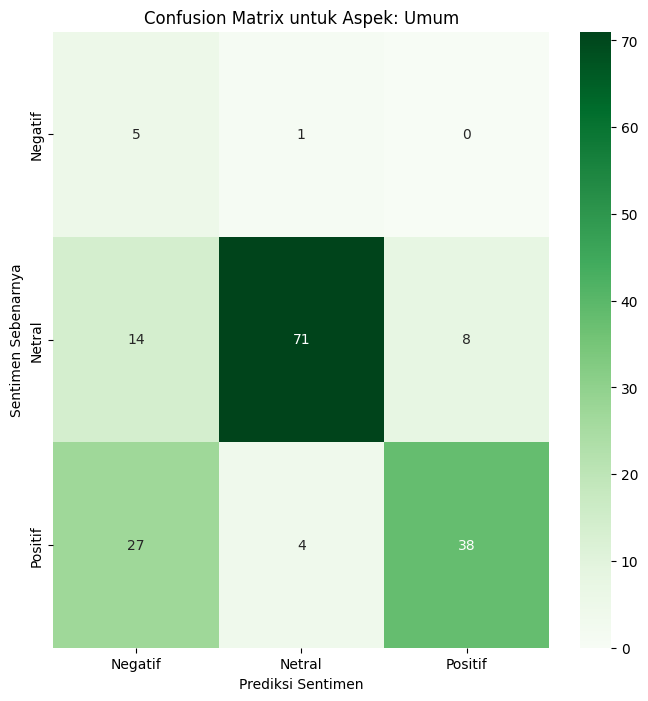

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_aspect_sentiment_confusion_matrices_3x3(
    aspect_targets, aspect_preds, sentiment_targets, sentiment_preds, aspect_encoder, sentiment_encoder
):
    """
    Plot 3x3 confusion matrices for each aspect with three sentiment levels (Negative=0, Neutral=1, Positive=2),
    filtered by aspect relevance.
    """
    # Definisikan label sentimen asli (0, 1, 2)
    sentiment_labels = [0, 1, 2]
    sentiment_names = ["Negatif", "Netral", "Positif"]

    # Iterasi untuk setiap aspek
    for i, aspect_name in enumerate(aspect_encoder.classes_):
        # Filter data untuk aspek tertentu (hanya data yang relevan)
        relevant_indices = [idx for idx, target in enumerate(aspect_targets) if target[i] == 1]
        aspect_sentiment_true = [sentiment_targets[idx] for idx in relevant_indices]
        aspect_sentiment_pred = [sentiment_preds[idx] for idx in relevant_indices]

        # Jika tidak ada data untuk aspek ini, lewati
        if not aspect_sentiment_true or not aspect_sentiment_pred:
            print(f"Tidak ada data relevan untuk aspek {aspect_name}")
            continue

        # Hitung confusion matrix
        cm = confusion_matrix(aspect_sentiment_true, aspect_sentiment_pred, labels=sentiment_labels)

        # Visualisasi confusion matrix menggunakan sns.heatmap dengan palet hijau
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=sentiment_names, yticklabels=sentiment_names)
        plt.title(f"Confusion Matrix untuk Aspek: {aspect_name}")
        plt.xlabel("Prediksi Sentimen")
        plt.ylabel("Sentimen Sebenarnya")
        plt.show()

# Memanggil fungsi visualisasi setelah pelatihan
aspect_targets, aspect_preds, sentiment_targets, sentiment_preds = train(model, train_loader, val_loader)

plot_aspect_sentiment_confusion_matrices_3x3(
    aspect_targets=aspect_targets,  # Target multi-label untuk aspek
    aspect_preds=aspect_preds,      # Prediksi aspek untuk data validasi
    sentiment_targets=sentiment_targets,  # Target sentimen untuk data validasi
    sentiment_preds=sentiment_preds,      # Prediksi sentimen untuk data validasi
    aspect_encoder=aspect_encoder,   # Encoder aspek yang digunakan
    sentiment_encoder=sentiment_encoder  # Encoder sentimen yang digunakan
)


## **Prediksi Aspek & Sentimen**

In [ ]:
import torch
import numpy as np

# Muat model dan tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertMultiTask(num_aspects, num_sentiments)
model.load_state_dict(torch.load("./bert-multilingual-multitask", map_location=device))
model.to(device)
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def predict_multiple_aspects_and_sentiments(kalimat, model, tokenizer, aspect_encoder, sentiment_encoder):
    # Tokenisasi kalimat
    encoded_data = tokenizer.encode_plus(
        kalimat,
        add_special_tokens=True,
        return_attention_mask=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )

    input_ids = encoded_data["input_ids"].to(device)
    attention_mask = encoded_data["attention_mask"].to(device)

    # Melakukan prediksi tanpa perhitungan gradien
    with torch.no_grad():
        model.eval()
        aspect_logits, sentiment_logits = model(input_ids, attention_mask)

        # Prediksi aspek (multi-label dengan sigmoid)
        aspect_probs = torch.sigmoid(aspect_logits).cpu().numpy()[0]

        # Ambil top-k aspek dengan probabilitas tertinggi
        top_k_aspects = 3  # Bisa disesuaikan
        aspect_indices = np.argsort(aspect_probs)[-top_k_aspects:]
        aspect_predictions = np.zeros_like(aspect_probs)
        aspect_predictions[aspect_indices] = 1

        # Prediksi multiple sentimen
        sentiment_probs = torch.softmax(sentiment_logits, dim=1).cpu().numpy()[0]
        top_k_sentiments = 2  # Bisa disesuaikan
        sentiment_indices = np.argsort(sentiment_probs)[-top_k_sentiments:]

    # Konversi prediksi aspek ke label, hanya tampilkan jika probabilitas > threshold
    threshold_aspect = 0.3  # Ambang batas probabilitas aspek
    predicted_aspects = [
        aspect_encoder.inverse_transform([i])[0]
        for i in range(len(aspect_predictions))
        if aspect_predictions[i] == 1 and aspect_probs[i] > threshold_aspect  # Filter aspek yang relevan
    ]

    # Konversi prediksi sentimen ke label, hanya tampilkan jika probabilitas > threshold
    threshold_sentiment = 0.3  # Ambang batas probabilitas sentimen
    sentiment_dict = {2: 'positif', 1: 'netral', 0: 'negatif'}  # Pastikan sesuai dengan mapping
    predicted_sentiments = [
        sentiment_dict[i] for i in sentiment_indices if sentiment_probs[i] > threshold_sentiment  # Filter sentimen yang relevan
    ]

    return predicted_aspects, predicted_sentiments

# Contoh kalimat yang ingin diprediksi
kalimat = "tidak bisa berlangganan, kenapa ya"

# Prediksi aspek dan sentimen
predicted_aspects, predicted_sentiments = predict_multiple_aspects_and_sentiments(
    kalimat, model, tokenizer, aspect_encoder, sentiment_encoder
)

# Tampilkan hasil prediksi
print(f"Kalimat: {kalimat}")
print(f"Aspek Prediksi: {predicted_aspects}")
print(f"Sentimen Prediksi: {predicted_sentiments}")


<ipython-input-49-f5aee0dd8454>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./bert-multilingual-multitask", map_location=device))


Kalimat: tidak bisa berlangganan, kenapa ya
Aspek Prediksi: ['Pelayanan']
Sentimen Prediksi: ['negatif']
